# Assignment 1: Mandelbrot Set

In [33]:
import numpy as np
import matplotlib.pyplot as plt

## Excercise 1

### Defining a class for the Mandelbrot Set

In [34]:
class Mandelbrot:
    """
    A class to generate and visualize the Mandelbrot set on a complex plane.

    Methods
    -------
    
    """
    def __init__(self, width, height, x_range, y_range, max_iterations):
        """
        Attributes
        ----------
        width : int
            The width (in pixels) of the output image.
        height : int
            The height (in pixels) of the output image.
        x_min : float
            The minimum value of the real axis.
        x_max : float
            The maximum value of the real axis.
        y_min : float
            The minimum value of the imaginary axis.
        y_max : float
            The maximum value of the imaginary axis.
        max_iterations : int
            The maximum number of iterations to determine if a point belongs to the Mandelbrot set.
        """

        self.width = width
        self.height = height
        self.x_min, self.x_max = x_range
        self.y_min, self.y_max = y_range
        self.max_iterations = max_iterations
        
        #meshgrid of complex numbers
        self.x_coords = np.linspace(self.x_min, self.x_max, self.width)
        self.y_coords = np.linspace(self.y_min, self.y_max, self.height)
        self.X, self.Y = np.meshgrid(self.x_coords, self.y_coords)
        self.C = self.X + 1j * self.Y
        
        #init Mandelbrot set array
        self.mandelbrot_set = np.zeros((self.height, self.width), dtype=int)
    
    def generate(self):
        """
        Computes the Mandelbrot set by iterating over each complex number in the plane.

        Returns
        -------
        mandelbrot_set : numpy.ndarray
            A 2D array where each element represents the iteration count at which the corresponding point diverged, or `max_iterations` if it is within the Mandelbrot set.
        """
        #iterate over the complex plane
        Z = np.zeros_like(self.C, dtype=np.complex128)
        iterations = np.zeros_like(self.C, dtype=int)
        
        mask = np.ones_like(self.C, dtype=bool)
        for n in range(self.max_iterations):
            Z[mask] = Z[mask]**2 + self.C[mask]
            diverged = np.abs(Z) > 2
            self.mandelbrot_set[mask & ~diverged] = n
            mask[diverged] = False
            if not np.any(mask):
                break

        return self.mandelbrot_set
        
    def is_stable(self, c, iterations):
        
        # Convert single complex number to numpy array if needed
        if isinstance(c, complex):
            c = np.array([c], dtype=np.complex128)
        
        # Initialize arrays
        z = np.zeros_like(c)
        mask = np.ones(c.shape, dtype=bool)
        
        # Iterate only on points that haven't escaped
        for _ in range(iterations):
            z[mask] = z[mask] * z[mask] + c[mask]
            mask[np.abs(z) > 2] = False
            if not np.any(mask):
                break
        
        # For single input, return scalar boolean
        if len(mask) == 1:
            return mask[0]
        return mask

    def calc_area_random_uniform(self, samples, iterations=0):
        
        # Generate all random points at once
        real = np.random.uniform(self.x_min, self.x_max, samples)
        imag = np.random.uniform(self.y_min, self.y_max, samples)
        points = real + 1j * imag
        
        # Calculate stability for all points at once
        stable_points = self.is_stable(points, iterations)
        
        # Calculate area
        total_area = (self.x_max - self.x_min) * (self.y_max - self.y_min)
        set_area = total_area * (np.sum(stable_points) / samples)
        
        return set_area

### Running and Visualizing

In [35]:
m = Mandelbrot(1000,1000,(-2.0,0.8),(-1.3,1.3),150)
m_set = m.generate()

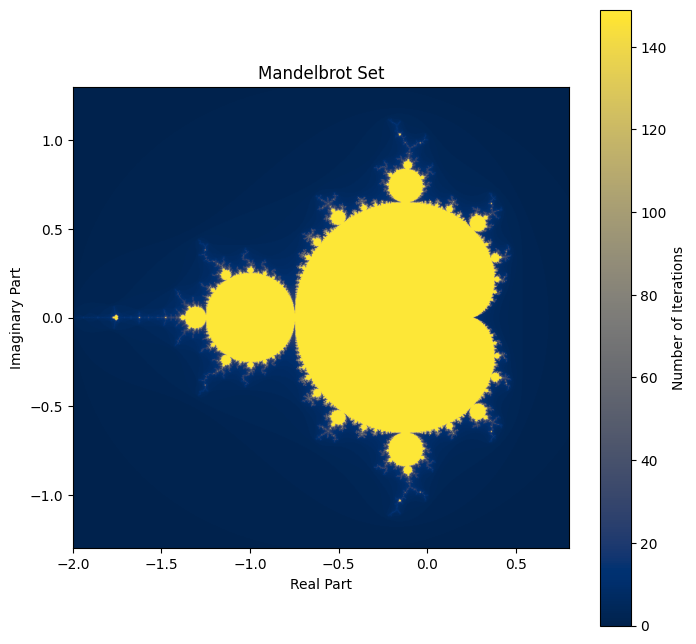

In [36]:
# Generate a nice heatmap of the data
plt.figure(figsize = (8, 8))
plt.imshow(m_set,  extent = (m.x_min, m.x_max, m.y_min, m.y_max), cmap = 'cividis')
plt.colorbar(label = 'Number of Iterations')
plt.title("Mandelbrot Set")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.show()

## Excercise 2

A_{M} ≅  1.5116555999999999


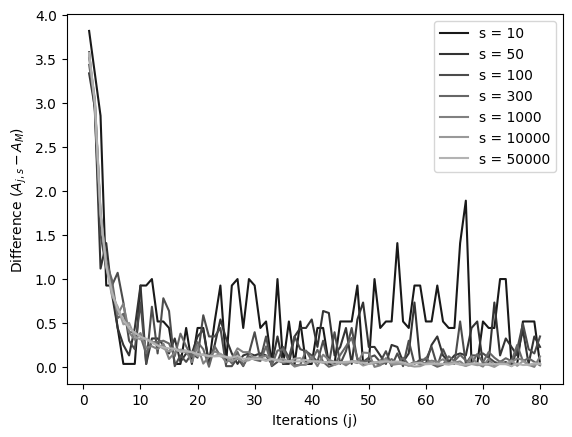

In [37]:
# Calculate an estimate of A_{M}
A_M = m.calc_area_random_uniform(200000, 10000)
print(r'A_{M} ≅ ', A_M)

# Create lists of all i and s
steps = 80
list_i = [1]
list_s = [10, 50, 100, 300, 1000, 10000, 50000]

for step in range(1, steps):
    list_i.append(list_i[step - 1] + 1)

# Define dictionary to store the estimated areas for each i, for each s
dic_diff = {s: [] for s in list_s}

for i in list_i:
    for s in list_s:
        diff = abs(m.calc_area_random_uniform(s, i) - A_M) / A_M
        dic_diff[s].append(diff)

# Plot the differences with A_{M} for every estimated area
for index, (s, diff) in enumerate(dic_diff.items()):
    plt.plot(list_i, diff, color = plt.cm.gray(0.1 + 0.6 * (index / (len(list_s) - 1))), label = f's = {s}')

plt.xlabel('Iterations (j)')
plt.ylabel(r'Difference ($A_{j, s} - A_{M}$)')
plt.legend()
plt.show()